## IMPORTANT NOTICE

This notebook is only included for legacy purposes. It was written for a previous version of the model, when early stopping and 24h parallelization was not implemented yet. Since then, a lot of the project structure, class names and function signatures have changed, so the cells down below are outdated.

## Import ISO-NE Data

In [1]:
from data_importers.iso_ne_importer import import_data
from examples.dotdict import dotdict

example = dotdict(import_data(demand_file="data_importers/data/iso_ne_demand.csv",
                         offer_file="data_importers/data/iso_ne_offer.csv"))
print("Data imported")

Data imported


## Import Iteration Log

In [10]:
import numpy as np

def read_iteration_logs(file):
    data = []
    while True:
        line = file.readline()
        if not line:
            return data
        elif line == "\n":
            break
        else:
            value = np.fromstring(line.replace("[", "").replace("]", ""), sep=",")
            data.append(value)

log_names = ["0-3-before-changes", "f-0-3-before-changes", "0-3-early-stopping"]
data = {}

for name in log_names:
    file = open(f"./jupyter-inputs/segments-iteration-logging-iso-ne-{name}", "r")
    data[name] = read_iteration_logs(file)
    file.close()

## Calculate optimal solution

Solve problem with gurobi

In [7]:
from gurobi_solver.exact_gurobi_mip import Exact_Gurobi_Mip
from lib.welfare import welfare

gurobi_model = Exact_Gurobi_Mip(
    buyer_valuations=example.buyer_valuations,
    seller_valuations=example.seller_valuations,
    seller_fixed_costs=example.seller_fixed_costs,
    buyer_bounds=example.buyer_bounds,
    seller_bounds=example.seller_bounds
)
gurobi_solution = gurobi_model.solve()
gurobi_welfare = welfare(gurobi_solution, example)

## Calculate statistics

Calculate the welfare, number of violated constraints as well as total constraint violation extent for each iteration step

In [11]:
from constraint_violation import count_violated_constraints, total_constraint_violation_extent

vcs_by_step = {}
tcve_by_step = {}
uts_by_step = {}

for name in log_names:
    vcs_by_step[name] = []
    tcve_by_step[name] = []
    uts_by_step[name] = []
    for i in range(len(data[name])):
        vcs_by_step[name].append(count_violated_constraints(data[name][i], example))
        tcve_by_step[name].append(total_constraint_violation_extent(data[name][i], example))
        uts_by_step[name].append(welfare(data[name][i], example))

## Visualize statistics

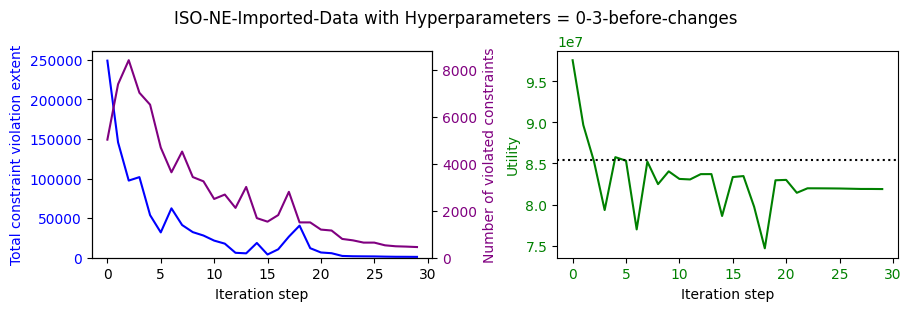

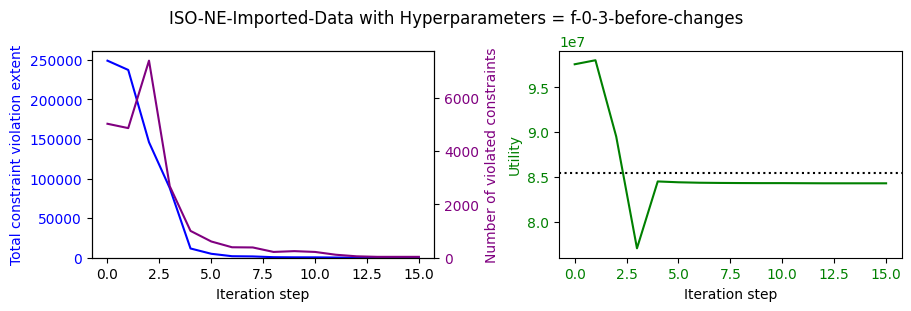

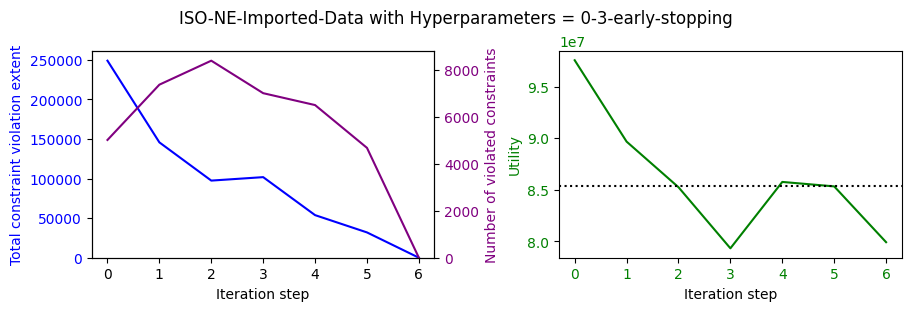

In [12]:
import matplotlib.pyplot as plt

for name in log_names:
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(9, 3), constrained_layout=True)
    
    ax1.plot(range(0, len(data[name])), tcve_by_step[name], color="blue")
    ax1.set_xlabel("Iteration step")
    ax1.set_ylabel("Total constraint violation extent", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.set_ylim(ymin=0)
    ax2 = ax1.twinx()
    
    ax2.plot(range(0, len(data[name])), vcs_by_step[name], color="purple")
    ax2.set_ylabel("Number of violated constraints", color="purple")
    ax2.tick_params(axis="y", labelcolor="purple")
    ax2.set_ylim(ymin=0)
    
    ax3.plot(range(0, len(data[name])), uts_by_step[name], color="green")
    ax3.set_xlabel("Iteration step")
    ax3.axhline(y=gurobi_welfare, color="black", linestyle="dotted")
    ax3.set_ylabel("welfare", color="green")
    ax3.tick_params(labelcolor="green")
    
    fig.suptitle(f"{example.name} with Hyperparameters = {name}")
    plt.show()